In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
from tqdm import tqdm
from utils import*
import gc
import scipy as scipy

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import cg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# .Obj file handling part

In [2]:
points_c=get_file_obj("./data/dargon.obj")

In [3]:
print(points_c.shape)

torch.Size([100250, 6])


In [4]:
dico=dict()
bord=get_borders(points_c)

create_quadtree(dico,0,11,points_c,bord,"")

In [5]:
bord=get_borders(points_c)

In [6]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

def get_dico_final(dico,D):
    new_dico=dict()

    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):

            for i in range(1,9):
                tmp_node=node[:-1]+str(i)
                new_dico[tmp_node]=dico[tmp_node]
    return new_dico
        

def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    L_indexes=dict()
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()

                if node[:-2] in L_indexes:
                    L_indexes[node[:-2]][0].append(cpt_p)
                else:
                    _,new_c,_,_,_,_=dico[node[:-2]]
                    L_indexes[node[:-2]]=([cpt_p],new_c)
                    
                
                cpt_p+=1
    return s_p,o_s,L_indexes


def get_V_tmp(coords_grid,l_o,l_s):
    #q [ r_x , r_y , r_z,  3 ]
    #     0    1     2    3

    q=coords_grid.clone().unsqueeze(3).unsqueeze(4).repeat(1,1,1,l_o.shape[0],8,1).to(device) 
    #q [ r_x , r_y , r_z, l_o , 8 , 3 ]
    #     0     1     2    3    4   5

    q[:,:,:,:,:,0]-=l_o[:,:,2]
    q[:,:,:,:,:,0]/=l_o[:,:,1]
    q[:,:,:,:,:,1]-=l_o[:,:,3]
    q[:,:,:,:,:,1]/=l_o[:,:,1]
    q[:,:,:,:,:,2]-=l_o[:,:,4]
    q[:,:,:,:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q)**2,dim=5)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    

    res=l_s[:,3:].clone().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device) 
    res=res.repeat(coords_grid.shape[0],coords_grid.shape[1],coords_grid.shape[2],1,8,1).to(device) 
    



    res[:,:,:,:,0,0]*=test[:,:,:,:,0]
    res[:,:,:,:,0,1]*=test[:,:,:,:,0]
    res[:,:,:,:,0,2]*=test[:,:,:,:,0]
    res[:,:,:,:,1,0]*=test[:,:,:,:,1]
    res[:,:,:,:,1,1]*=test[:,:,:,:,1]
    res[:,:,:,:,1,2]*=test[:,:,:,:,1]
    res[:,:,:,:,2,0]*=test[:,:,:,:,2]
    res[:,:,:,:,2,1]*=test[:,:,:,:,2]
    res[:,:,:,:,2,2]*=test[:,:,:,:,2]
    res[:,:,:,:,3,0]*=test[:,:,:,:,3]
    res[:,:,:,:,3,1]*=test[:,:,:,:,3]
    res[:,:,:,:,3,2]*=test[:,:,:,:,3]
    res[:,:,:,:,4,0]*=test[:,:,:,:,4]
    res[:,:,:,:,4,1]*=test[:,:,:,:,4]
    res[:,:,:,:,4,2]*=test[:,:,:,:,4]
    res[:,:,:,:,5,0]*=test[:,:,:,:,5]
    res[:,:,:,:,5,1]*=test[:,:,:,:,5]
    res[:,:,:,:,5,2]*=test[:,:,:,:,5]
    res[:,:,:,:,6,0]*=test[:,:,:,:,6]
    res[:,:,:,:,6,1]*=test[:,:,:,:,6]
    res[:,:,:,:,6,2]*=test[:,:,:,:,6]
    res[:,:,:,:,7,0]*=test[:,:,:,:,7]
    res[:,:,:,:,7,1]*=test[:,:,:,:,7]
    res[:,:,:,:,7,2]*=test[:,:,:,:,7]

    
    
    res=torch.sum(res,dim=(3,4)).to(device) 
   
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )


# Computation of the vector field

In [7]:
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_vec(points_c,dico,D,name=None):
    
    l_s,l_o,indexes=get_os(points_c.shape[0],dico,D)

    batch_size=32
    bgrid=32

    

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    resolution=64
    
    width_x=max_x-min_x
    width_y=max_y-min_y
    width_z=max_z-min_z

    size_grid_x=width_x/resolution
    size_grid_y=width_y/resolution
    size_grid_z=width_z/resolution
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)

    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    grid_res=torch.zeros((resolution,resolution,resolution,3))
    
    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z
    
    

    

    
    for key in tqdm(indexes):
        tmp_l,tmp_c=indexes[key]
        for i in range(0,len(tmp_l),batch_size):

           

         

            batch_idxs=tmp_l[i:i+batch_size]
            

            tmp_l_s=l_s[batch_idxs].to(device) 
            tmp_l_o=l_o[batch_idxs].to(device)
    
            c_x_g = ((torch.min(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)
            c_y_g = ((torch.min(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)
            c_z_g = ((torch.min(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)

            c_x_d = ((torch.max(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)+bgrid
            c_y_d = ((torch.max(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)+bgrid
            c_z_d = ((torch.max(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)+bgrid

            c_x_g=max(0,c_x_g-bgrid)
            c_y_g=max(0,c_y_g-bgrid)
            c_z_g=max(0,c_z_g-bgrid)
            
            tmp_grid=grid_coords[c_x_g:c_x_d,c_y_g:c_y_d,c_z_g:c_z_d].to(device)
            tmp_res=get_V_tmp(tmp_grid,tmp_l_o,tmp_l_s).detach().cpu()
            tmp_verif=tmp_res.clone()
            tmp_verif[1:-1,1:-1,1:-1,:]=0.0
            if torch.sum(torch.abs(tmp_verif))>3:
                
                c_x_g = ((torch.min(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)
                c_y_g = ((torch.min(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)
                c_z_g = ((torch.min(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)
    
                c_x_d = ((torch.max(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)+bgrid*2
                c_y_d = ((torch.max(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)+bgrid*2
                c_z_d = ((torch.max(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)+bgrid*2
    
                c_x_g=max(0,c_x_g-bgrid*2)
                c_y_g=max(0,c_y_g-bgrid*2)
                c_z_g=max(0,c_z_g-bgrid*2)    
            else:
                grid_res[c_x_g:c_x_d,c_y_g:c_y_d,c_z_g:c_z_d]+=tmp_res
            
    
               
                
       
            
    
    torch.cuda.empty_cache()
    gc.collect()

    if name!=None:
        np.save(name,grid_res.numpy().astype(np.single))
    else:
        return grid_res
        
    

      
values=get_V_vec(points_c,dico,D=6)   

100%|██████████| 2625/2625 [01:38<00:00, 26.73it/s]


# Computation of the Divergence.

In [8]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1], V.shape[2]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :,:] += (V[2:, :,:, 0] - V[:-2, :,:, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1,:] += (V[:, 2:,:, 1] - V[:, :-2,:, 1]) / 2
    div_V[:, :,1:-1] += (V[:,: ,2:, 2] - V[:, :, :-2, 2]) / 2
    
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :,:] += (V[1, :,:, 0] - V[0, :,:, 0])
    div_V[-1, :,:] += (V[-1, :,:, 0] - V[-2, :,:, 0])
    div_V[:, 0,:] += (V[:, 1,:, 1] - V[:, 0,:, 1])
    div_V[:, -1,:] += (V[:, -1,:, 1] - V[:, -2,:, 1])
    div_V[:,:, 0] += (V[:, :,1, 1] - V[:,:, 0, 1])
    div_V[:,:, -1] += (V[:, :,-1, 1] - V[:,:, -2, 1])

    return div_V

    

In [9]:
grad=compute_divergence(values)

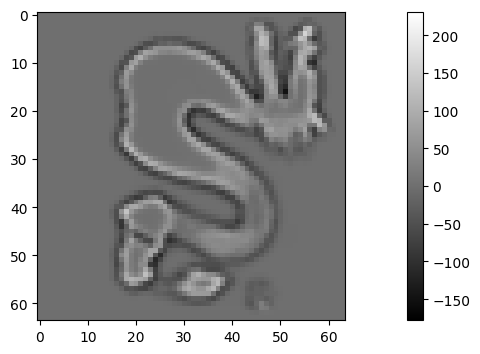

In [10]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=32
ax = fig.add_subplot(1, 1, 1)
plt.imshow(grad[:,:,slice],cmap="gray",vmin=torch.min(grad),vmax=torch.max(grad))
plt.colorbar()

#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)


# List of Gaussian kernels

In [11]:
def get_list_gaussians(borders,D):
    res_centers=torch.empty(8**D,4)

    min_x=borders[0]#.item()
    max_x=borders[1]#.item()
    min_y=borders[2]#.item()
    max_y=borders[3]#.item()
    min_z=borders[4]#.item()
    max_z=borders[5]#.item()

    Width=(max_x-min_x)/(2**D)

    tmp_grid=torch.empty((2**D,2**D,2**D,3))

   
    i=min_x+torch.arange(0,2**D,1)*Width+Width/2.0
    j=min_y+torch.arange(0,2**D,1)*Width+Width/2.0
    w=min_z+torch.arange(0,2**D,1)*Width+Width/2.0


    grid_x, grid_y, grid_z = torch.meshgrid(i, j, w, indexing='ij')

    tmp_grid[:,:,:,0]=grid_x
    tmp_grid[:,:,:,1]=grid_y
    tmp_grid[:,:,:,2]=grid_z

    res_centers[:,0]=tmp_grid[:,:,:,0].flatten()
    res_centers[:,1]=tmp_grid[:,:,:,1].flatten()
    res_centers[:,2]=tmp_grid[:,:,:,2].flatten()
    res_centers[:,3]=Width

    return res_centers

In [21]:

Depth_gauss=5
bord=get_borders(points_c)
L_gaussians=get_list_gaussians(bord,Depth_gauss)
print(L_gaussians.shape)

torch.Size([32768, 4])


# Computation of < B , V >

In [22]:

def get_inner_product_gradVB_new(V,L_gaussians,borders):
    V=V.to(device) 
    L_gaussians=L_gaussians.to(device) 

    
    
    res=torch.empty(L_gaussians.shape[0])

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    w_x=max_x-min_x
    w_y=max_y-min_y
    w_z=max_z-min_z

    resolution=V.shape[0]
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)
    
    
    grid_coords=torch.zeros((resolution,resolution,resolution,3)).to(device) 
    

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')
 
    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    
    


    for idx_gaussian in tqdm(range(L_gaussians.shape[0])):
        
        tmp_sum_g=((grid_coords[:,:,:,0]-L_gaussians[idx_gaussian,0])/L_gaussians[idx_gaussian,3])**2
        tmp_sum_g+=((grid_coords[:,:,:,1]-L_gaussians[idx_gaussian,1])/L_gaussians[idx_gaussian,3])**2
        tmp_sum_g+=((grid_coords[:,:,:,2]-L_gaussians[idx_gaussian,2])/L_gaussians[idx_gaussian,3])**2
        
        tmp_sum_g=torch.exp(-(tmp_sum_g/(1.5**2)))/L_gaussians[idx_gaussian,3]**3
        
        tmp_sum_g=tmp_sum_g*V
        tmp_sum_g=torch.sum(tmp_sum_g*((w_x*w_y*w_z)/resolution**3))
        res[idx_gaussian]=tmp_sum_g.detach().cpu()

    V=V.detach().cpu()
    L_gaussians=L_gaussians.detach().cpu()
    torch.cuda.empty_cache()
    gc.collect()
        
    
    
        
    return res

In [23]:
#V_o_prec=get_inner_product_gradVB_new(grad,L_gaussians,bord)
#V_o=get_inner_product_gradVB_new_vec(grad,L_gaussians,bord)
V_o=get_inner_product_gradVB_new(grad,L_gaussians,bord)

100%|██████████| 32768/32768 [00:08<00:00, 3768.15it/s]


# Computation of < B'' , B >

In [24]:
def get_indexes_BB(id_ligne,L_gaussians,D):
    

    tmp_ker=L_gaussians[id_ligne,:]

    tmp_L_g=L_gaussians[id_ligne:id_ligne+15*4**D,:]
    

    tmp_L_g=torch.sqrt(torch.sum((tmp_L_g[:,:3]-tmp_ker[:3])**2,dim=(1)))/tmp_ker[3]
    b= tmp_L_g <=12

    
    return id_ligne+b.nonzero().flatten()

def get_vec_idxs_new(L_gaussians,D):
    vec_ixds=torch.empty((0,2))
    vec_idx_half=torch.empty((0,2))

    idx_half_start=2**D*2**D*((2**D)/2.0)
    idx_half_end=idx_half_start+4**D
    
    print("computation of matrix indexes")
    for idx_gaussian_1 in tqdm(range(4**D)):
        indexes=get_indexes_BB(idx_gaussian_1,L_gaussians,D)
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gaussian_1
        vec_idx_half=torch.cat((vec_idx_half,tmp_list),0)

    #for idx_gauss in tqdm(range(0,15*4**D)):
    #    indexes=get_indexes_BB(int(idx_gauss),L_gaussians,D)
    #    tmp_list=torch.zeros((indexes.shape[0],2))
    #    tmp_list[:,0]=indexes
    #    tmp_list[:,1]=idx_gauss
    #    vec_ixds=torch.cat((vec_ixds,tmp_list),0)

    for layer in tqdm(range(0,8**D-15*4**D,4**D)):
        tmp_index=vec_idx_half.clone()
        vec_ixds=torch.cat((vec_ixds,tmp_list),0)

    for idx_gauss in tqdm(range(8**D-15*4**D,8**D)):
        indexes=get_indexes_BB(int(idx_gauss),L_gaussians,D)
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gauss
        vec_ixds=torch.cat((vec_ixds,tmp_list),0)
        
        

    return vec_ixds

In [25]:
#vec_ixds=get_vec_idxs_new(L_gaussians,Depth_gauss)

In [31]:
def get_indexes_BB(id_ligne,L_gaussians,D):
    

    tmp_ker=L_gaussians[id_ligne,:]

    tmp_L_g=L_gaussians[id_ligne:id_ligne+15*4**D,:]
    

    tmp_L_g=torch.sqrt(torch.sum((tmp_L_g[:,:3]-tmp_ker[:3])**2,dim=(1)))/tmp_ker[3]
    b= tmp_L_g <=10

    
    return id_ligne+b.nonzero().flatten()

def get_vec_idxs(L_gaussians,D):
    vec_ixds=torch.empty((0,2))
    
    print("computation of matrix indexes")
    for idx_gaussian_1 in tqdm(range(L_gaussians.shape[0])):
        indexes=get_indexes_BB(idx_gaussian_1,L_gaussians,D)
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gaussian_1
        vec_ixds=torch.cat((vec_ixds,tmp_list),0)

    return vec_ixds



def get_inner_product_gradB_B_sparse_vec(size_grid,vec_ixds, L_gaussians, borders,D):
    
    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)

    
    

    batch_size=512



    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()

    width_x = max_x - min_x
    width_y = max_y - min_y
    width_z = max_z - min_z

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=size_grid)
    
    x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

    grid = torch.empty(size_grid, size_grid, size_grid, 3)
    grid[:, :, :, 0] = x
    grid[:, :, :, 1] = y
    grid[:, :, :, 2] = z

    

    
    print("computation of the matrix")
    for batch in tqdm(range(0,vec_ixds.shape[0],batch_size)):

        
        Width=L_gaussians[0,3]
        coords_g1=L_gaussians[vec_ixds[batch:batch+batch_size,1].to(torch.int)].to(device)
        coords_g1=coords_g1[:,:3].unsqueeze(1).unsqueeze(1).unsqueeze(1).expand((-1,size_grid,size_grid,size_grid,-1))
        coords_g2=L_gaussians[vec_ixds[batch:batch+batch_size,0].to(torch.int)].to(device)
        coords_g2=coords_g2[:,:3].unsqueeze(1).unsqueeze(1).unsqueeze(1).expand((-1,size_grid,size_grid,size_grid,-1))

        taille_batch = coords_g2.shape[0]
        grid_tmp= grid.clone().to(device).unsqueeze(0).repeat((taille_batch, 1, 1, 1, 1))

        
        gauss_1=( (grid_tmp.clone()-coords_g1) / Width )**2
        gauss_1= torch.exp(-torch.sum(gauss_1,dim=4)/(1.5**2))
        gauss_1x= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 0]-coords_g1[:, :, :, :, 0])/(1.5**2))/Width**3
        gauss_1y= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 1]-coords_g1[:, :, :, :, 1])/(1.5**2))/Width**3
        gauss_1z= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 2]-coords_g1[:, :, :, :, 2])/(1.5**2))/Width**3

        gauss_2=( (grid_tmp.clone()-coords_g2) / Width )**2
        gauss_2= torch.exp(-torch.sum(gauss_2,dim=4)/(1.5**2))
        gauss_2x= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 0]-coords_g2[:, :, :, :, 0])/(1.5**2)))/Width**3
        gauss_2y= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 1]-coords_g2[:, :, :, :, 1])/(1.5**2)))/Width**3
        gauss_2z= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 2]-coords_g2[:, :, :, :, 2])/(1.5**2)))/Width**3
        

        
        
        tmp_res=-torch.sum(gauss_1x*gauss_2x*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))
        tmp_res+=-torch.sum(gauss_1y*gauss_2y*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))
        tmp_res+=-torch.sum(gauss_1z*gauss_2z*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))

        
        sparse_indexes = torch.cat((sparse_indexes,vec_ixds[batch:batch+batch_size].permute(1,0) ), dim=1)
        sparse_values = torch.cat((sparse_values, tmp_res.detach().cpu()), dim=0)

        tmp_vec_idxs_flip=torch.empty(vec_ixds[batch:batch+batch_size].shape)
        tmp_vec_idxs_flip[:,0]=vec_ixds[batch:batch+batch_size,1]
        tmp_vec_idxs_flip[:,1]=vec_ixds[batch:batch+batch_size,0]

        tmp_vec_idxs_flip_boolean=(tmp_vec_idxs_flip[:,0]!=tmp_vec_idxs_flip[:,1]).nonzero()

        tmp_vec_idxs_flip=tmp_vec_idxs_flip[tmp_vec_idxs_flip_boolean,][:,0,:]
       
        tmp_res=tmp_res[tmp_vec_idxs_flip_boolean][:,0]

        sparse_indexes = torch.cat((sparse_indexes,tmp_vec_idxs_flip.permute(1,0) ), dim=1)
        sparse_values = torch.cat((sparse_values, tmp_res.detach().cpu()), dim=0)
        
        
    
        

    
    sparse_indexes=sparse_indexes.detach().cpu()
    sparse_values=sparse_values.detach().cpu()
     
    #np.save("./L_oo/indexes_"+str(D)+".npy",sparse_indexes.numpy().astype(np.single))
    #np.save("./L_oo/values_"+str(D)+".npy",sparse_values.numpy().astype(np.single))
    torch.cuda.empty_cache()
    gc.collect()

    return sparse_indexes,sparse_values#torch.sparse_coo_tensor(sparse_indexes, sparse_values,size=(8**D, 8**D))
        

        
        


    
    return id_ligne+b.nonzero().flatten()

def get_Loo(L_gaussians,D,borders):

    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)
    
    vec_ixds=torch.empty((0,2))
    vec_idx_half=torch.empty((0,2))

    idx_half_start=2**D*2**D*((2**D)/2.0)
    idx_half_end=idx_half_start+4**D

    
    size_grid=64
    
    print("computation of the first slice indexes")
    for idx_gaussian_1 in tqdm(range(4**D)):
        indexes=get_indexes_BB(idx_gaussian_1,L_gaussians,D)
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gaussian_1
        vec_idx_half=torch.cat((vec_idx_half,tmp_list),0)

    indexes_half,values_half=get_inner_product_gradB_B_sparse_vec(size_grid,vec_idx_half, L_gaussians, borders,D)
        
    print("replication in the sparse matrix")
    for layer in tqdm(range(0,8**D,4**D)):
        indexes_half_tmp=indexes_half.clone()+layer
        
        mask=(indexes_half_tmp[0] < L_gaussians.shape[0]) & (indexes_half_tmp[1] < L_gaussians.shape[0])
        
        indexes_half_tmp=indexes_half_tmp[:, mask]
        values_half_tmp = values_half.clone()[mask]
        
        
        
        sparse_indexes = torch.cat((sparse_indexes,indexes_half_tmp ), dim=1)
        sparse_values = torch.cat((sparse_values,values_half_tmp), dim=0)
        
        
        
    
    
    
        

    return sparse_indexes,sparse_values





In [33]:
#L_oo=get_inner_product_gradB_B(grad.shape[0],L_gaussians,bord)
#L_gaussians=L_gaussians.detach().cpu()
#vec_ixds=get_vec_idxs(L_gaussians,Depth_gauss)
#print(vec_ixds.shape)
loo_indexes,loo_values=get_Loo(L_gaussians,Depth_gauss,bord)

computation of the first slice indexes


100%|██████████| 1024/1024 [00:00<00:00, 2272.99it/s]


computation of the matrix


100%|██████████| 3233/3233 [06:24<00:00,  8.40it/s]


replication in the sparse matrix


100%|██████████| 32/32 [00:02<00:00, 11.91it/s]


In [34]:
#np.save("vec_idxs_6.npy",vec_ixds.numpy().astype(np.single))
#vec_ixds=torch.from_numpy(np.load("vec_idxs_6.npy"))

In [35]:
torch.cuda.empty_cache()
gc.collect()
#L_oo=get_inner_product_gradB_B_sparse_prec(8, L_gaussians, bord,5)
#L_oo=get_inner_product_gradB_B_sparse_vec(16,vec_ixds,L_gaussians,bord,D=Depth_gauss)


0

In [36]:

if L_gaussians.shape[0]<=512:
    tmp_L_oo=scipy.sparse.coo_matrix((loo_values.numpy(), loo_indexes.numpy()), shape=(8**Depth_gauss, 8**Depth_gauss))
    plt.imshow(tmp_L_oo.todense())
    plt.colorbar()

# Linear system solving

In [53]:
def tmp_callback(xk):
    pass

tmp_L_oo=scipy.sparse.coo_matrix((loo_values.numpy(), loo_indexes.numpy()), shape=(8**Depth_gauss, 8**Depth_gauss))
A = csc_matrix(tmp_L_oo)
B=V_o.numpy()

eps, exit_code = cg(A, B,rtol=1e1)
print(exit_code)

eps=torch.from_numpy(np.array(eps))

0


In [50]:
import torch.optim as optim

L_oo=torch.sparse_coo_tensor(loo_indexes, loo_values,size=(8**Depth_gauss, 8**Depth_gauss))

def grad_loss(L,img,V):
    return (torch.mean((torch.sparse.mm(L,img.view((img.shape[0],1)))-V.view((V.shape[0],1)))**2))


def fit(L,V):
    optimizer=optim.LBFGS([torch.zeros(0)],lr=1e-1, max_iter=500)
    eps_b=V.clone()#torch.randn(V.shape)
    eps_b.requires_grad = True
    optimizer.param_groups[0]['params'][0] = eps_b

    def closure():
        optimizer.zero_grad()
        loss=grad_loss(L,eps_b,V)
        print(loss)
        loss.backward(retain_graph=True)
        return loss
    loss=optimizer.step(closure)
    print(loss)
    
    return eps_b

eps=fit(L_oo,V_o)

eps=eps.detach()
print(eps.shape)

tensor(9.2460e+09, grad_fn=<MeanBackward0>)
tensor(9.2460e+09, grad_fn=<MeanBackward0>)
tensor(6.9893e+09, grad_fn=<MeanBackward0>)
tensor(5.7009e+09, grad_fn=<MeanBackward0>)
tensor(4.6377e+09, grad_fn=<MeanBackward0>)
tensor(3.7691e+09, grad_fn=<MeanBackward0>)
tensor(3.0619e+09, grad_fn=<MeanBackward0>)
tensor(2.4869e+09, grad_fn=<MeanBackward0>)
tensor(2.0198e+09, grad_fn=<MeanBackward0>)
tensor(1.6404e+09, grad_fn=<MeanBackward0>)
tensor(1.3324e+09, grad_fn=<MeanBackward0>)
tensor(1.0824e+09, grad_fn=<MeanBackward0>)
tensor(8.7948e+08, grad_fn=<MeanBackward0>)
tensor(7.1475e+08, grad_fn=<MeanBackward0>)
tensor(5.8104e+08, grad_fn=<MeanBackward0>)
tensor(4.7250e+08, grad_fn=<MeanBackward0>)
tensor(3.8439e+08, grad_fn=<MeanBackward0>)
tensor(3.1285e+08, grad_fn=<MeanBackward0>)
tensor(2.5477e+08, grad_fn=<MeanBackward0>)
tensor(2.0760e+08, grad_fn=<MeanBackward0>)
tensor(1.6928e+08, grad_fn=<MeanBackward0>)
tensor(1.3815e+08, grad_fn=<MeanBackward0>)
tensor(1.1286e+08, grad_fn=<Mean

KeyboardInterrupt: 

In [54]:
#grid resolution
n_p=64

min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

width_x=max_x-min_x
width_y=max_y-min_y
width_z=max_y-min_z

image_res=torch.zeros((n_p,n_p,n_p))

xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=n_p)
ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=n_p)
zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=n_p)

x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

grid = torch.empty(n_p, n_p, n_p, 3)
grid[:, :, :, 0] = x
grid[:, :, :, 1] = y
grid[:, :, :, 2] = z


def get_X(x,l_g,q):
    
    #res=torch.sum(torch.exp(-torch.sum(((q-l_g[:,:3])/l_g[0,3])**2)/(1.5**2))*x)
    res=torch.sum(torch.exp((-torch.sum(((q.to(device)-l_g[:,:3]).to(device)/l_g[0,3].to(device))**2,dim=1))/1.5**2)*x)
    
    #res=torch.sum(torch.exp(-( ((q[0] - l_g[:,0])/l_g[:,3])**2 + ((q[1] - l_g[:,1])/l_g[:,3])**2 + ((q[2] - l_g[:,2])/l_g[:,3])**2 ) / l_g[0,3]**2)*x)

    return res
        


L_gaussians=L_gaussians.to(device) 
eps=eps.clone().to(device) 


for i in tqdm(range(xs.shape[0])):
    for j in range(xs.shape[0]):
        for w in range(xs.shape[0]):
        
            image_res[i,j,w]=get_X(eps,L_gaussians,grid[i,j,w].to(device) ).detach().cpu()

def get_isovalue(eps,l_g,l_p):
     res=torch.zeros(l_p.shape)
     for idx_p in tqdm(range(l_p.shape[0])):
         tmp_p=l_p[idx_p,:3]
         res[idx_p]=get_X(eps,l_g,tmp_p)
     return res.mean()

iso_val=get_isovalue(eps,L_gaussians,points_c)
print(iso_val)

100%|██████████| 100250/100250 [00:16<00:00, 6250.82it/s]

tensor(0.)


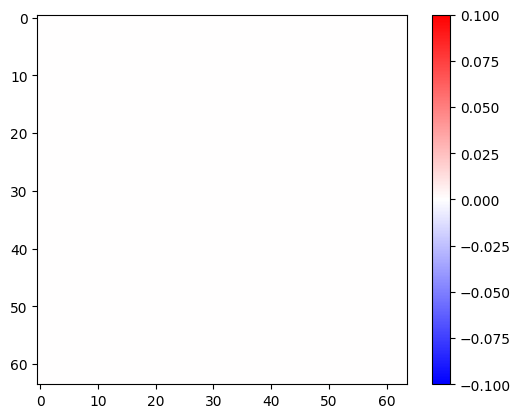

In [56]:
slice=32
plt.imshow(image_res[:,:,slice],cmap="bwr")
plt.colorbar()

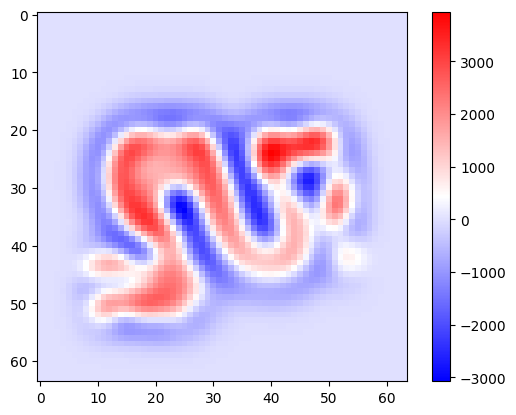

In [46]:
slice=32
plt.imshow(image_res[:,:,slice],cmap="bwr")
plt.colorbar()

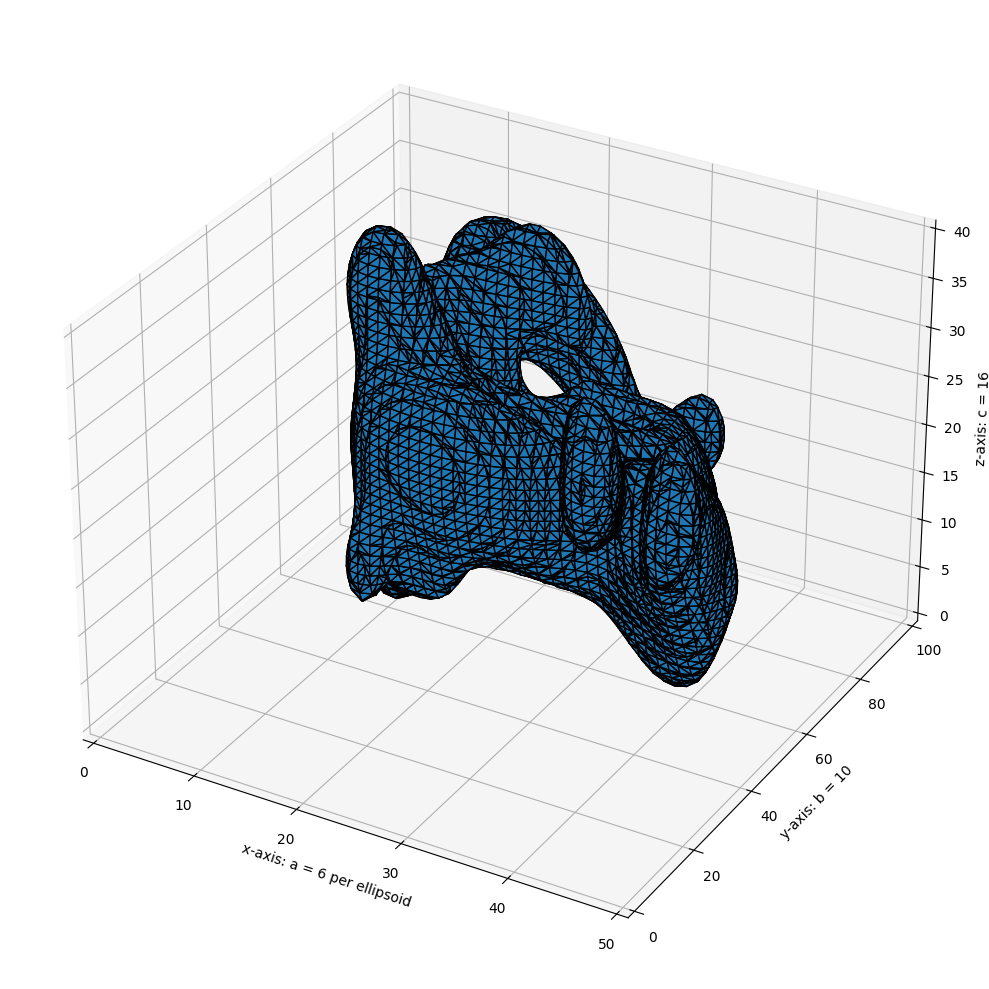

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(image_res.numpy())


# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 100)  # b = 10
ax.set_zlim(0, 40)  # c = 16

plt.tight_layout()
plt.show()
